In [10]:
import os

DATA_DIR = os.path.join("english")

In [4]:
next(os.walk(os.path.join(DATA_DIR, 'Durian')))

('english\\Durian',
 [],
 ['aligned.swc',
  'audio.ogg',
  'audiometa.txt',
  'info.json',
  'wiki.html',
  'wiki.txt',
  'wiki.xml'])

In [4]:
import xml.etree.ElementTree as ET
from typing import List

import numpy as np


class PronunciationTiming(object):

    def __init__(self, word: str, start: int, end: int) -> None:
        self.word = word
        self.start = start
        self.end = end

class SWC(object):

    def __init__(self, swc_path: str) -> None:
        self.tree = ET.parse(swc_path)
        self.timings = []

    def get_timings(self) -> List[PronunciationTiming]:
        if len(self.timings) > 0:
            return self.timings
        # https://www.geeksforgeeks.org/xml-parsing-python/
        root = self.tree.getroot()
        doc = root.find('d')

        for p in doc.findall('p'):
            for s in p.findall('s'):
                for t in s.findall('t'):
                    for n in t.findall('n'):
                        attribs = n.attrib
                        if 'pronunciation' not in attribs \
                            or 'start' not in attribs or 'end' not in attribs:
                            continue
                        word = attribs['pronunciation'].lower()
                        self.timings.append(PronunciationTiming(
                            word,
                            int(attribs['start']),
                            int(attribs['end'])))
        return self.timings

In [5]:
from typing import Tuple

from pydub import AudioSegment


def split_clip(audio: AudioSegment, swc: SWC
               ) -> Tuple[List[str], List[AudioSegment]]:
    words = []
    clips = []
    for p in swc.get_timings():
        words.append(p.word)
        clip = audio[p.start:p.end]
        # https://github.com/jiaaro/pydub/blob/master/API.markdown#audiosegmentget_array_of_samples
        # clip = audio[p.start:p.end].get_array_of_samples()
        # fp_arr = np.array(clip).T.astype(np.float32)
        # fp_arr /= np.iinfo(clip.typecode).max
        clips.append(clip)
    return words, clips

audio = AudioSegment.from_ogg('english/Durian/audio.ogg')
# print(audio.channels, audio.frame_rate)
swc = SWC('english/Durian/aligned.swc')
split_clip(audio, swc)

(['trees',
  'from',
  'the',
  'genus',
  'durio',
  'belonging',
  'to',
  'the',
  'durionaceae',
  'family',
  'widely',
  'known',
  'revered',
  'in',
  'southeast',
  'asia',
  'as',
  'the',
  'king',
  'of',
  'fruits',
  'the',
  'fruit',
  'is',
  'distinctive',
  'large',
  'size',
  'unique',
  'odour',
  'and',
  'formidable',
  'thorn',
  'covered',
  'husk',
  'fruit',
  'can',
  'grow',
  'up',
  'to',
  'thirty',
  'centimetres',
  'twelve',
  'in',
  'long',
  'and',
  'centimetres',
  'six',
  'in',
  'in',
  'diameter',
  'and',
  'typically',
  'weighs',
  'one',
  'three',
  'kilograms',
  'to',
  'seven',
  'l',
  'b',
  'its',
  'shape',
  'ranges',
  'from',
  'oblong',
  'to',
  'round',
  'the',
  'colour',
  'of',
  'its',
  'husk',
  'green',
  'to',
  'brown',
  'and',
  'its',
  'flesh',
  'pale',
  'yellow',
  'to',
  'red',
  'depending',
  'on',
  'the',
  'species',
  'edible',
  'flesh',
  'emits',
  'distinctive',
  'odour',
  'strong',
  'and',
  

In [6]:
from typing import Optional


class PronunciationClip(object):
    def __init__(self, word: str, audio: AudioSegment) -> None:
        self.word = word
        self.audio = audio

    def __repr__(self) -> str:
        return f"PronunciationClip({repr(self.word)}, {repr(self.audio)})"

def load_utterances(limit: Optional[int] = 5000, vocab: List[str] = None
                    ) -> List[PronunciationClip]:
    clips = []

    for dir in os.listdir(DATA_DIR):
        path = os.path.join(DATA_DIR, dir)
        if not os.path.isdir(path):
            continue
        files = os.listdir(path)
        if 'audio.ogg' not in files or 'aligned.swc' not in files:
            continue
        try:
            audio = AudioSegment.from_ogg(os.path.join(path, 'audio.ogg'))
        except:  # noqa: E722
            print(f'Failed to decode file: {os.path.join(path, "audio.ogg")}')
            continue
        swc = SWC(os.path.join(path, 'aligned.swc'))
        words, pcms = split_clip(audio, swc)
        for w, c in zip(words, pcms):
            # skip words less than 4 chars long or not in vocab
            if len(w) < 4 \
                or vocab is not None and w not in vocab:
                continue
            clips.append(PronunciationClip(w, c))

        if limit is not None and len(clips) > limit:
            break
    return clips

In [7]:
clips = load_utterances(None) # 50 minutes to load 100,000 clips
print(len(clips))
clips[0]

Failed to decode file: english\Caesium\audio.ogg
Failed to decode file: english\Fuck_(film)\audio.ogg
Failed to decode file: english\Spinning_Around\audio.ogg
100283


PronunciationClip('cant', <pydub.audio_segment.AudioSegment object at 0x0000017DCCD26180>)

In [11]:
def make_noise_playlist(path: os.PathLike, limit: int = 0) -> List[AudioSegment]:
    clips = []
    for f in os.listdir(path):
        if not f.endswith('wav'):
            continue
        file_path = os.path.join(path, f)
        clips.append(AudioSegment.from_file(file_path))
        if limit > 0 and len(clips) > limit:
            break
    return clips


# music_clips = make_noise_playlist(os.path.join('audio', 'music'), 200)
# outdoor_clips = make_noise_playlist(os.path.join('audio', 'outside_rural'))

In [12]:
# https://github.com/mcdermottLab/pycochleagram
import pycochleagram.cochleagram as cgram
from scipy import ndimage

N_FILTERS = 50
LO_LIM = 30
HI_LIM = 7860
SAMPLE_RATE = 16000

def gen_clip(audio: AudioSegment, duration: int = 2000) -> AudioSegment:
    clip = AudioSegment.silent(duration=duration, frame_rate=SAMPLE_RATE)
    audio_duration = len(audio)
    offset = max(0, duration / 2 - (audio_duration / 2))
    return clip.overlay(audio, offset)

def audio_to_cgram(audio: AudioSegment) -> np.array:
    # TODO: find audio input type for cochleagram (8-bit integer PCM?)
    arr = np.array(audio.get_array_of_samples())
    return cgram.human_cochleagram(arr, audio.frame_rate or SAMPLE_RATE,
                                   N_FILTERS, LO_LIM, HI_LIM, 4, downsample=200)

def aa_cgram(cochleagram: np.ndarray, size: int = 256) -> np.ndarray:
    f, t = cochleagram.shape
    kx = size / f
    ky = size / t
    return ndimage.zoom(cochleagram, (kx, ky))

# a = gen_clip(clips[0].audio)
# c = audio_to_cgram(a)
# aa = aa_cgram(c)
# c.shape, aa.shape # 211x400, 256x256


In [71]:
import array


def overlay_noise(snr: float, signal: AudioSegment, noise: AudioSegment
                  ) -> AudioSegment:
    signal = signal.normalize()
    # gain = snr - signal.dBFS + noise.dBFS
    # scaled_noise = noise.apply_gain(-gain)
    # signal_rms = signal.rms
    s = np.array(signal.get_array_of_samples())
    ss = np.square(s)
    print(np.min(s), np.max(s))
    print(np.min(ss), np.max(ss))
    signal_rms = np.sqrt(np.mean(s**2))
    noise_rms = noise.rms
    scaling_factor = signal_rms / noise_rms * 10**(-snr/20)
    print(snr, scaling_factor, signal_rms, noise_rms)
    noise_np = np.array(noise.set_channels(1).get_array_of_samples())
    print(np.min(noise_np), np.max(noise_np))
    noise_samples = noise_np * scaling_factor
    print(np.min(noise_samples), np.max(noise_samples))
    noise_array = array.array(noise.array_type, np.round(noise_samples).astype(int))
    scaled_noise = noise._spawn(noise_array)
    return signal.overlay(scaled_noise, loop=True)

# noise = AudioSegment.from_file('audio/outside_rural/snipped119_start_240_end_250.wav')
# overlay_noise(2.0, gen_clip(clips[0].audio), noise)

### Count word frequencies to consider which data points we will keep

{'whiskers': [<matplotlib.lines.Line2D at 0x17d81714260>,
 'caps': [<matplotlib.lines.Line2D at 0x17d81717c80>,
 'boxes': [<matplotlib.lines.Line2D at 0x17d81714560>],
 'medians': [<matplotlib.lines.Line2D at 0x17d817176b0>],
 'fliers': [<matplotlib.lines.Line2D at 0x17d81717440>],
 'means': []}

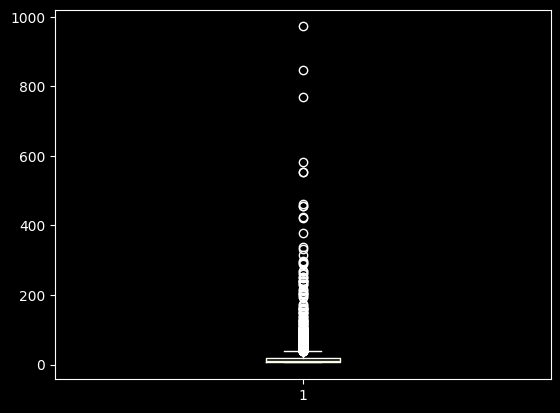

In [10]:
import matplotlib.pyplot as plt

freq_dict = {}
for pc in clips:
    freq_dict[pc.word] = freq_dict.get(pc.word, 0) + 1

freqs = list(filter(lambda x: 5 < x < 200000, freq_dict.values()))

plt.boxplot(freqs)

In [ ]:
def filter_clips(clips: List[PronunciationClip], min_freq: int = 20,
                 max_freq: int = 200) -> List[PronunciationClip]:
    freq_dict = {}
    for pc in clips:
        freq_dict[pc.word] = freq_dict.get(pc.word, 0) + 1
    included_words = list(filter(lambda w: min_freq < freq_dict[w] < max_freq,
                                 freq_dict.keys()))
    return list(filter(lambda c: c.word in included_words, clips))

In [14]:
wf = dict(filter(lambda x: 50 < x[1] < 300, freq_dict.items()))
print(f'{len(wf)} words remain after filtering')

with open('vocab.txt', 'w') as f:
    f.write("\n".join(wf.keys()))
    print('wrote vocabulary file')



NameError: name 'freq_dict' is not defined

In [15]:
from typing import Dict


def make_word2ind(clips: List[PronunciationClip]) -> Dict[str, int]:
    words2ind = {}
    words = set(c.word for c in clips)
    for i, w in enumerate(words):
        words2ind[w] = i
    return words2ind

def load_vocab(vocab_file: str = 'vocab.txt') -> List[str]:
    vocab = []
    with open(vocab_file, 'r') as f:
        vocab = f.read().strip().split('\n')
    print(f'Loaded vocabulary {vocab_file} with {len(vocab)} words.')
    return vocab

def filter_clips_vocab(clips: List[PronunciationClip], vocab: List[str]
                 ) -> List[PronunciationClip]:
    return list(filter(lambda c: c.word in vocab, clips))

### Save Audio Files

In [ ]:
vocab = load_vocab()
clips = load_utterances(20_000, vocab)

path = os.path.join('parsed_files', 'raw_clips')
os.makedirs(path, exist_ok = True)
for i, c in enumerate(clips):
    a = gen_clip(c.audio)
    a.export(os.path.join(path, f'{c.word}_{i}.wav'), format="wav")

In [8]:
def load_clips(path: str = 'parsed_files/raw_clips') -> List[PronunciationClip]:
    clips = []
    for fp in os.listdir(path):
        if not fp.endswith('.wav'):
            continue
        filename = os.path.join(path, fp)
        audio = AudioSegment.from_file(filename)
        word = fp.split('_')[0]
        clips.append(PronunciationClip(word, audio))
    return clips

In [ ]:
clips = load_clips()

word2ind = make_word2ind(clips)
print(f'{len(word2ind)} words from {len(clips)} clips')
word2ind

music_clips = make_noise_playlist(os.path.join('audio', 'music'), 200)
outdoor_clips = make_noise_playlist(os.path.join('audio', 'outside_rural'))
babble_clips = make_noise_playlist(os.path.join('audio', 'babble'))

In [72]:
import random

all_clips = []
all_targets = []


# music is -6dB mean, other noise is -3dB mean. all with 2dB variance
np.random.seed(123)
N = len(clips)
music_snr = np.random.normal(-6, 2, N)
outdoor_snr = np.random.normal(-3, 2, N)
babble_snr = np.random.normal(-3, 2, N)

m_path = os.path.join('parsed_files', 'music')
o_path = os.path.join('parsed_files', 'outdoor')
b_path = os.path.join('parsed_files', 'babble')

os.makedirs(m_path, exist_ok = True)
os.makedirs(o_path, exist_ok = True)
os.makedirs(b_path, exist_ok = True)

random.seed(123)
for i, clip in enumerate(clips):
    a = gen_clip(clip.audio)
    m_noise = random.choice(music_clips)
    o_noise = random.choice(outdoor_clips)
    b_noise = random.choice(babble_clips)
    m_clip = overlay_noise(music_snr[i], a, m_noise)
    o_clip = overlay_noise(outdoor_snr[i], a, o_noise)
    b_clip = overlay_noise(babble_snr[i], a, b_noise)
    m_cgram = aa_cgram(audio_to_cgram(m_clip))
    o_cgram = aa_cgram(audio_to_cgram(o_clip))
    b_cgram = aa_cgram(audio_to_cgram(b_clip))
    all_clips.append(m_cgram)
    all_clips.append(o_cgram)
    all_clips.append(b_cgram)

    fname = f'{clip.word}_{i}'

    m_clip.export(os.path.join(m_path, fname + '.wav'), format="wav")
    o_clip.export(os.path.join(o_path, fname + '.wav'), format="wav")
    b_clip.export(os.path.join(b_path, fname + '.wav'), format="wav")
    np.save(os.path.join(m_path, fname + '.npy'), m_cgram)
    np.save(os.path.join(o_path, fname + '.npy'), m_cgram)
    np.save(os.path.join(b_path, fname + '.npy'), m_cgram)

    word_id = word2ind[clip.word]
    all_targets.extend([word_id, word_id])

-1444474617 2122901605
-2147425735 2147209828
-8.171261206601123 nan nan 1990
-16801 15802
nan nan


C:\Users\nwong\AppData\Local\Temp\ipykernel_19328\2732737819.py:14: RuntimeWarning: invalid value encountered in sqrt
  signal_rms = np.sqrt(np.mean(s**2))
C:\Users\nwong\AppData\Local\Temp\ipykernel_19328\2732737819.py:22: RuntimeWarning: invalid value encountered in cast
  noise_array = array.array(noise.array_type, np.round(noise_samples).astype(int))


OverflowError: signed short integer is less than minimum